# Attr hw: investigate demographic patterns 

To do:
- look at number of people per grid cell/per country/per m2 
- number of children
- total number of people/children per country 
- combine shapefile and raster
- global bar plot number of people per age group 

Memo:
- fix bug in population data 

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), openpyxl, cartopy

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
try:
    import netCDF4
except: # for running in env-geosci lite (VS code) 
   pass
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline
# import my variables settings functions from other scripts
from settings import *
start_message()

from functions import *
from utils import *
from plotscript import *

/apps/brussel/RL8/broadwell/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


settings loaded
flags {'models': 'ISIMIP3b', 'metric': 'TX95', 'method': 'percentile', 'var': 'tasmax'} 
indirs: [' ', ' ', ' '] 
GCMs: ['none'] 
obs datasets: ['none'] 
lat chunk: 90 
lon chunk: 120 
time chunk: -1 
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output 
figdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/figures 
start_pi: 1850 
end_pi: 1900


In [2]:
# set figure path for saving

figdir = os.path.join(figdirs, 'fig_feb24_population-signal')

if not os.path.exists(figdir):
    os.makedirs(figdir)

### preprocess population data

Memo:
- do some exploration of demographics/spatial patterns of age groups in different countries (how many people in different countries, how many children - maybe normalized by surface area also !) 
- some mismatch of population/shapefiles ? 

In [3]:
sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! 


In [4]:
d_countries = preprocess_all_country_population_data()
gs_population_global = get_gridscale_population_global( 
    d_countries,
    startyear=2022,
    endyear=None,
    save=False # change where this gets saved !!!! now its in package folder
)

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero
Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated
calculating gridscale population per cou

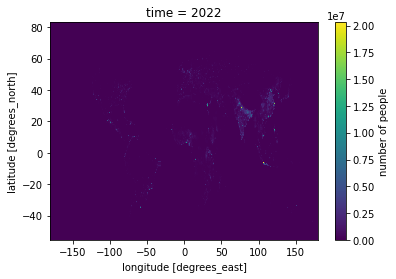

In [5]:
gs_population_global.sum(dim='ages').plot()
# highest latitudes where there is no population are cut !

/apps/brussel/RL8/broadwell/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/apps/brussel/RL8/broadwell/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


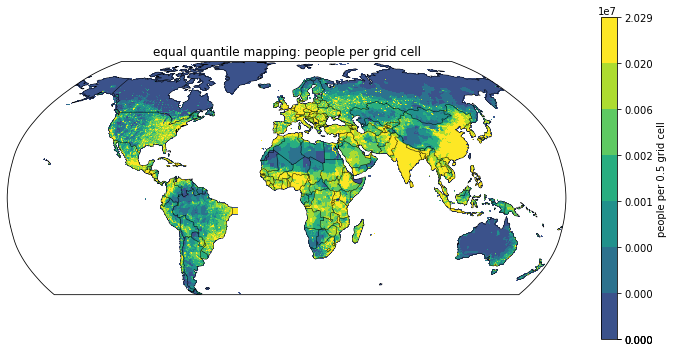

In [6]:
proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()

# Flatten the data and remove NaN values
data = gs_population_global.sum(dim='ages') * landmask # total pop over land
data_flat = data.values.flatten()
data_flat = data_flat[~np.isnan(data_flat)]

# Calculate the quantiles using numpy 
quantiles = np.nanpercentile(data_flat, np.linspace(0,100,10))

# Plot using matplotlib with equal quantile mapping 
(fig, ax) = plt.subplots(figsize=(10, 5),subplot_kw={'projection': proj})

plot = data.plot(ax=ax, cmap='viridis', levels=quantiles, cbar_kwargs={'label': 'people per 0.5 grid cell'}, transform=crs)

# Add coastlines
ax.coastlines(edgecolor='dimgray', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='k', linewidth=0.5 )


plt.title('equal quantile mapping: people per grid cell')
fig.tight_layout()

/apps/brussel/RL8/broadwell/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/apps/brussel/RL8/broadwell/software/xarray/2022.6.0-foss-2022a/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


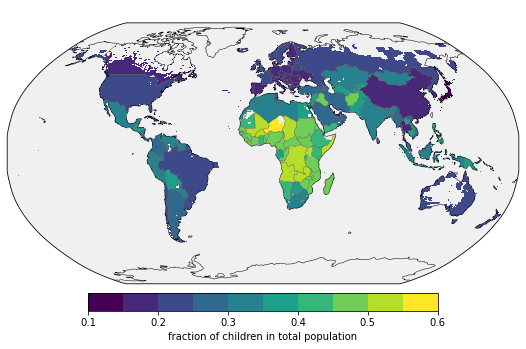

In [8]:

proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
whiteonblack = True

# set colors 
if whiteonblack == False:
    fg_color = 'white'
else:
    fg_color = 'k' 
    

data = gs_population_global.sel(ages=slice(0, 17)).sum(dim='ages') / gs_population_global.sum(dim='ages')

# Plot using matplotlib with specified colorbar label and coastlines
(fig, ax) = plt.subplots(figsize=(10,5),subplot_kw={'projection': proj})
plot = data.plot(ax=ax, transform=crs, levels=10,
                 add_colorbar=False
                 )
cb = fig.colorbar(plot, ax=ax, shrink=0.5, location='bottom', pad= 0.03,
                 label = 'fraction of children in total population') 
for spine in plot.axes.spines.values():
    spine.set_edgecolor(fg_color) 
    
ax.set_extent([-181, 181, -90, 90], crs=ccrs.PlateCarree()) # if you want to plot whole world

# Add coastlines
ax.coastlines(edgecolor='dimgray', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='dimgray', linewidth=0.5 )
ax.set_facecolor('#f0f0f0')

# change colors of stuff for white on black option 
cb.set_label('fraction of children in total population', color=fg_color)
cb.ax.yaxis.set_tick_params(color=fg_color)
cb.outline.set_edgecolor(fg_color)
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color=fg_color);

#plt.title('Proportion of Children in Total Population (2020)')
plt.title(' ')
plt.tight_layout()

#plt.savefig(os.path.join(figdir,'prop_children_global_bw.png'), dpi=300, transparent=False)
#plt.show()


# to do: make a version without the white spots where no pop ? 